# GNNs in neuroscience: graph convolutional networks for fMRI analysis

In [ ]:
!pip install nilearn
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.2 MB/s eta 0:00:00


In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 23.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-lsm1oz9f
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-lsm1oz9f
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit ed170342eb2b174fd16b910c735758edbd4e78fd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl size=11

In [ ]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import from_networkx

import networkx as nx

# Directories

In [ ]:
dataset_path = 'dataset'
corr_matrices_dir = f'{dataset_path}/corr_matrices'
pcorr_matrices_dir = f'{dataset_path}/pcorr_matrices'
avg_pcorr_file = f'{dataset_path}/avg_pcorr.csv'
time_series_dir = f'{dataset_path}/time_series'
labels_file = f'{dataset_path}/labels.csv'

os.makedirs(corr_matrices_dir)
os.makedirs(pcorr_matrices_dir)
os.makedirs(time_series_dir)

# Dataset

In [ ]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps
atlas_labels = atlas.labels

data = datasets.fetch_development_fmri()

 ...done. (2 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.



Dataset created in /root/nilearn_data/development_fmri


Added README.md to /root/nilearn_data/development_fmri


Dataset created in /root/nilearn_data/development_fmri/development_fmri



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


In [ ]:
atlas

{'maps': '/root/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
 'labels': ['L Aud',
  'R Aud',
  'Striate',
  'L DMN',
  'Med DMN',
  'Front DMN',
  'R DMN',
  'Occ post',
  'Motor',
  'R DLPFC',
  'R Front pol',
  'R Par',
  'R Post Temp',
  'Basal',
  'L Par',
  'L DLPFC',
  'L Front pol',
  'L IPS',
  'R IPS',
  'L LOC',
  'Vis',
  'R LOC',
  'D ACC',
  'V ACC',
  'R A Ins',
  'L STS',
  'R STS',
  'L TPJ',
  'Broca',
  'Sup Front S',
  'R TPJ',
  'R Pars Op',
  'Cereb',
  'Dors PCC',
  'L Ins',
  'Cing',
  'R Ins',
  'L Ant IPS',
  'R Ant IPS'],
 'region_coords': [[-53.28, -8.88, 32.36],
  [53.47, -6.49, 27.52],
  [1.18, -74.54, 10.79],
  [-45.8, -64.78, 31.84],
  [-0.2, -55.21, 29.87],
  [-0.15, 51.42, 7.58],
  [51.66, -59.34, 28.88],
  [0.41, -91.05, 1.58],
  [-1.48, -27.93, 61.5],
  [40.1, 20.96, 44.72],
  [37.83, 55.49, 1.22],
  [47.53, -52.42, 43.06],
  [62.53, -32.99, -9.14],
  [-0.91, -2.75, 6.15],
  [-41.66, -59.04, 44.61],
  [-39.04, 19.28, 43.27],
  [-40.08, 50.65, 0.8

In [ ]:
data

{'func': ['/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-pixar127_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-pixar128_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-pixar129_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/development_fmri/development_fmri/sub-p

In [ ]:
# standardize=True means signals in time series signals are shifted to zero mean and scaled to unit variance
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache')

In [ ]:
time_series = [0] * len(data.func)
labels = [0] * len(data.func)

In [ ]:
time_series,labels

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [ ]:
for i in range(0, len(data.func)):
    # Each subject is assigned a number.
    # We get this number here and use it as an index to avoid file ordering problems later.
    sub_num = int(data.phenotypic[i][0][9:]) - 1

    ts = masker.fit_transform(data.func[i], confounds=data.confounds[i])
    time_series[sub_num] = ts
    labels[sub_num] = data.phenotypic[i][3] # Whether or not the subject is a child or adult

# Save time series
for i in range(len(time_series)):
  np.savetxt(f'{time_series_dir}/time_series_{i:04d}.csv', time_series[i], delimiter=',')

/usr/local/lib/python3.10/dist-packages/nilearn/maskers/base_masker.py:268: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


In [ ]:
corr_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

# Get average partial correlation matrix across time series and save
avg_pcorr_matrix = np.mean(pcorr_matrices, axis=0)
np.savetxt(avg_pcorr_file, avg_pcorr_matrix, delimiter=',')

# Save correlation and partial correlation matrices
for i in range(0, len(corr_matrices)):
    np.savetxt(f'{corr_matrices_dir}/corr_{i:04d}.csv', corr_matrices[i], delimiter=',')
    np.savetxt(f'{pcorr_matrices_dir}/pcorr_{i:04d}.csv', pcorr_matrices[i], delimiter=',')

# Save labels
label_nums = [0 if label == 'child' else 1 for label in labels]
np.savetxt(labels_file, np.asarray(label_nums).astype(int), delimiter=',')

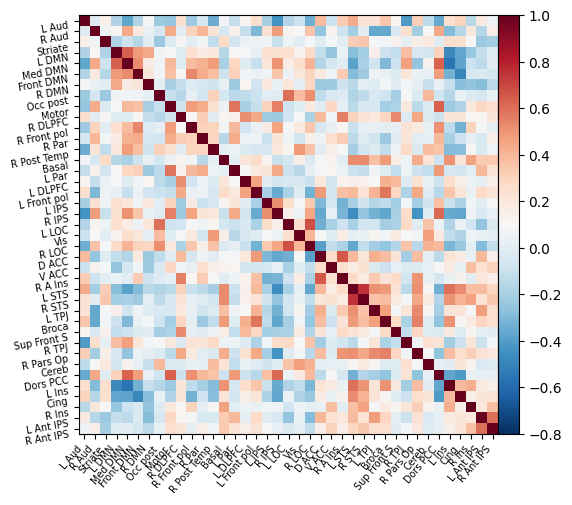

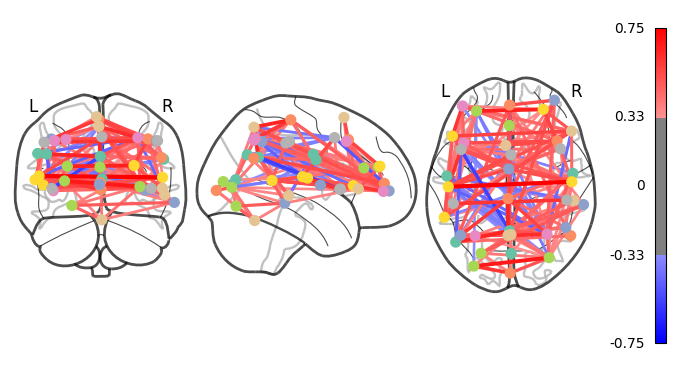

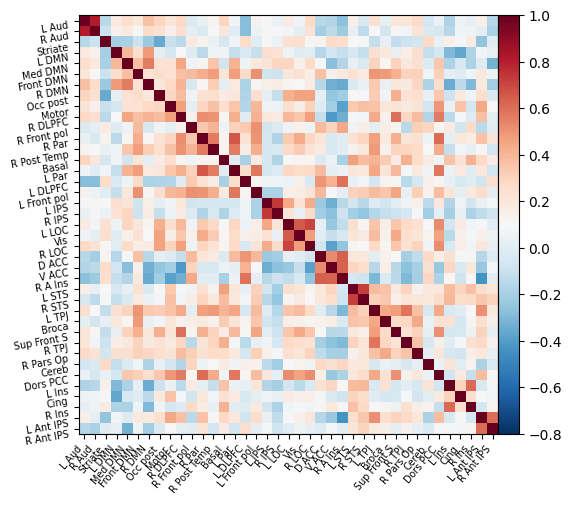

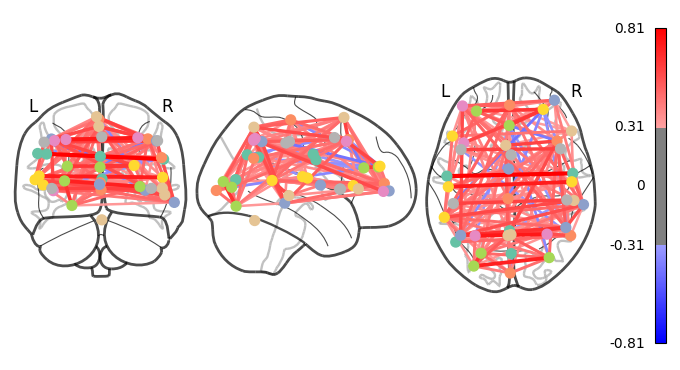

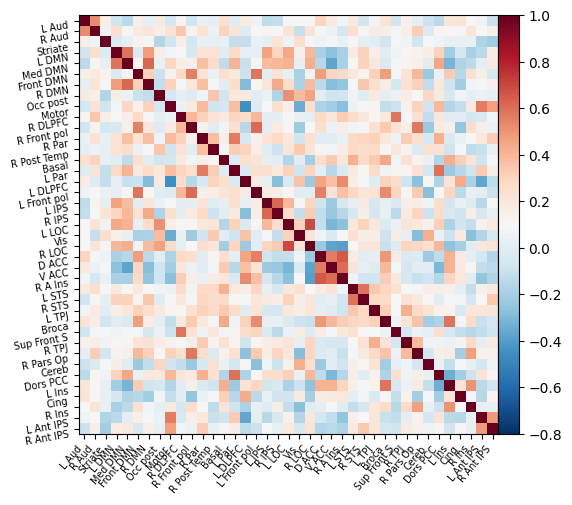

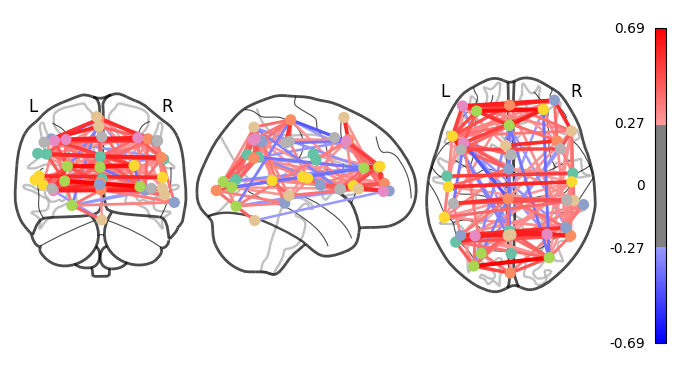

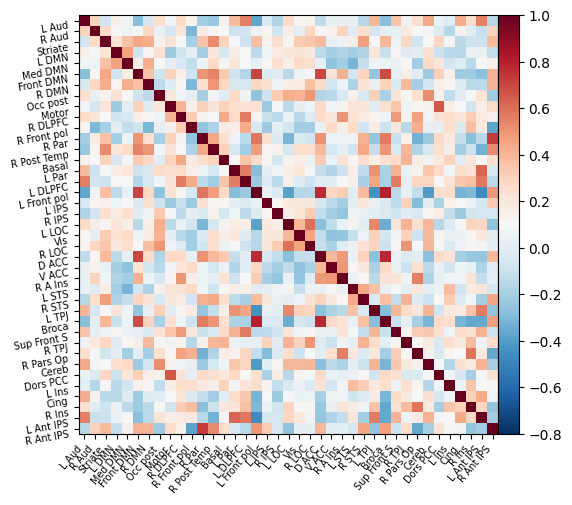

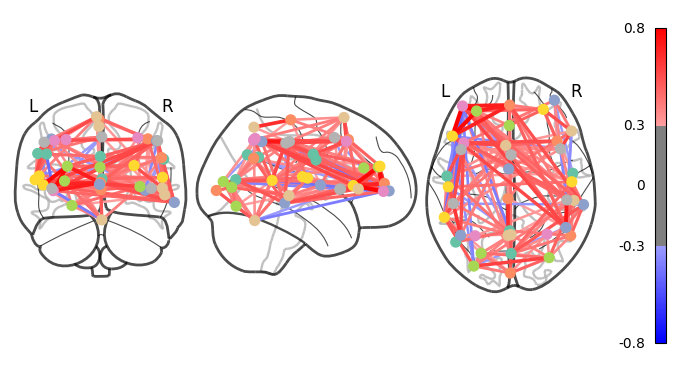

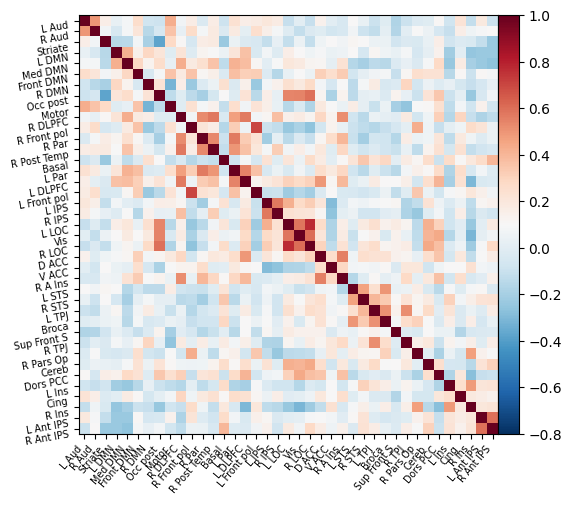

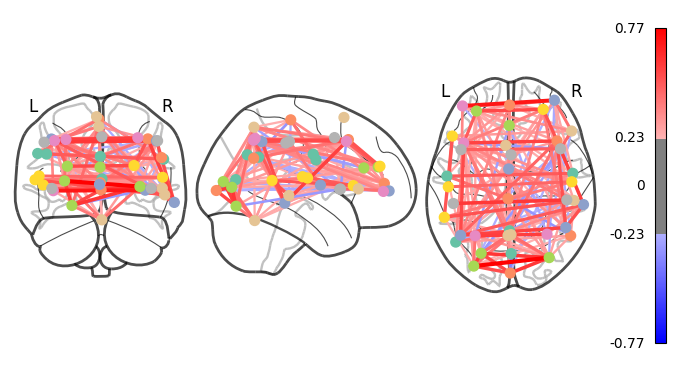

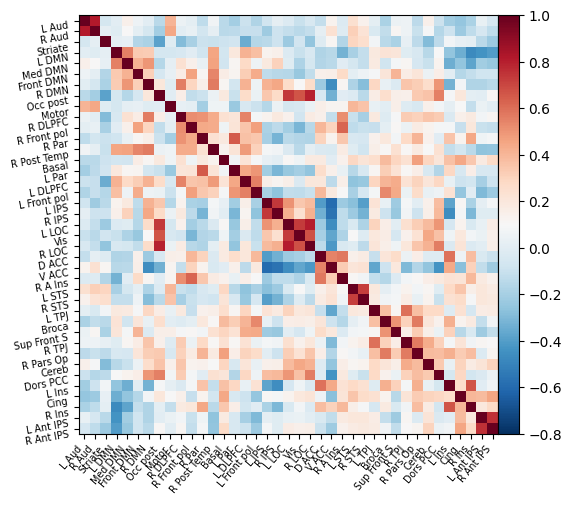

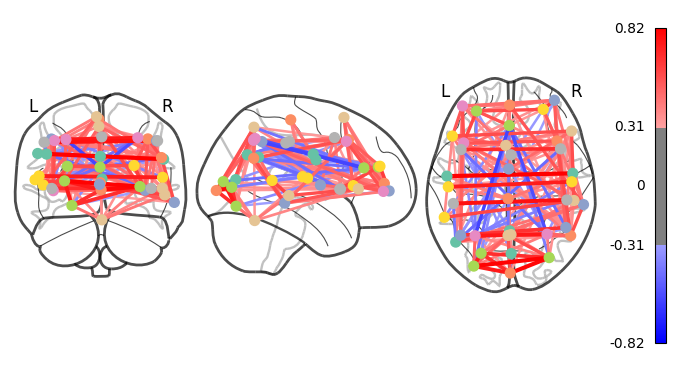

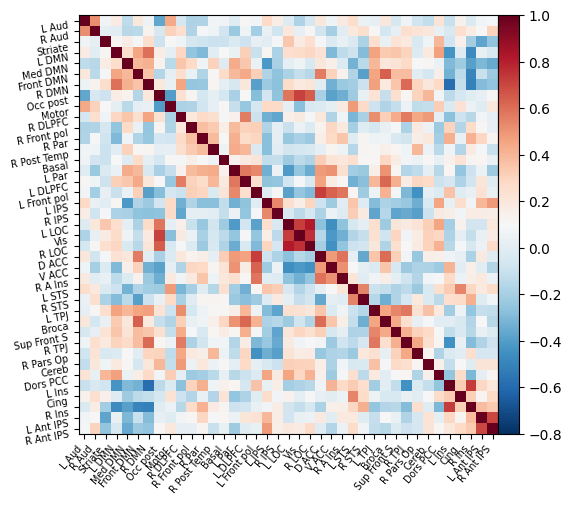

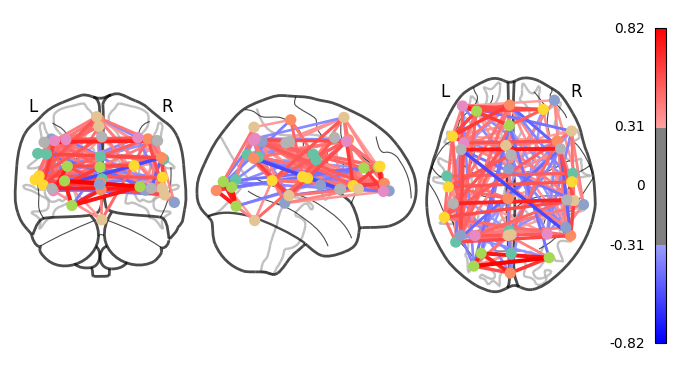

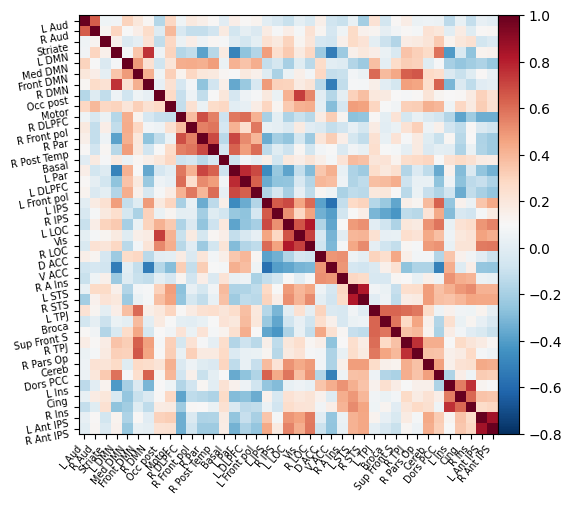

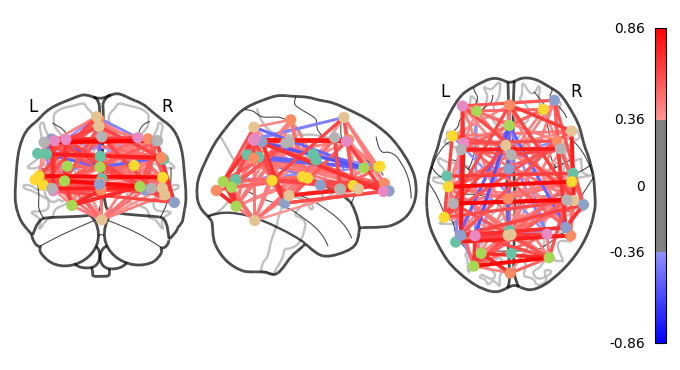

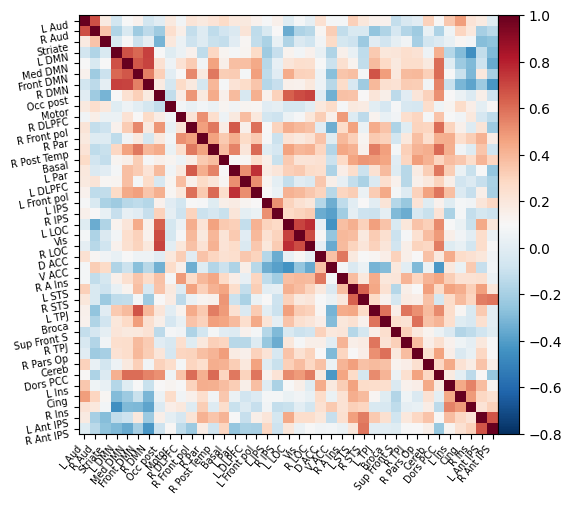

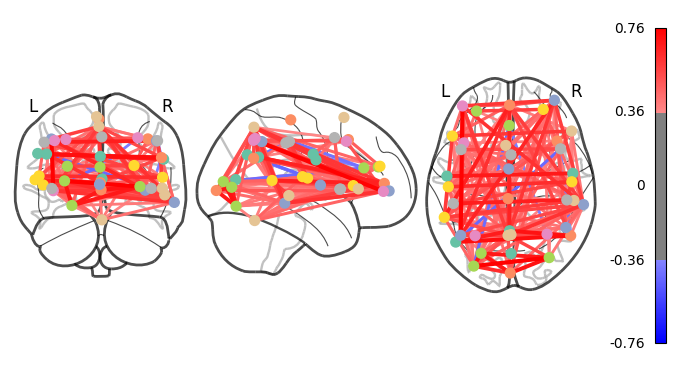

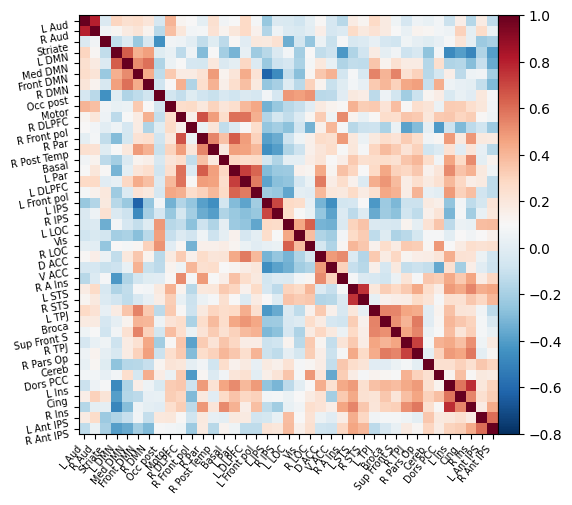

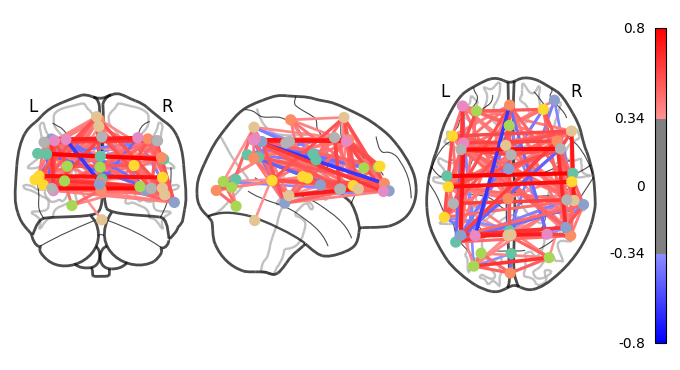

In [ ]:
index_consideration = [1,2, 5, 8, 16, -16, -8,-5,-2,-1]

# Plotting images side by side using a loop
for i in index_consideration:
  # Partial correlation matrix
  plotting.plot_matrix(corr_matrices[i], labels=atlas_labels, colorbar=True, vmax=1, vmin=-0.8)

  # Connectome over brain schematic
  coords = atlas.region_coords # Get center coordinates of each ROI
  plotting.plot_connectome(corr_matrices[i], coords, edge_threshold="80%", colorbar=True)


In [ ]:
class DevDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, neighbors=10):
        self.neighbors = neighbors
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        """ Converts raw data into GNN-readable format by constructing
        graphs out of connectivity matrices.

        """

        # Paths of connectivity matrices
        corr_path_list = sorted(os.listdir(corr_matrices_dir), key=lambda x: int(x[-8:-4]))
        pcorr_path_list = sorted(os.listdir(pcorr_matrices_dir), key=lambda x: int(x[-8:-4]))

        graphs = []
        labels = torch.from_numpy(np.loadtxt(labels_file, delimiter=','))
        for i in range(0, len(corr_path_list)):
            corr_matrix_path = os.path.join(corr_matrices_dir, corr_path_list[i])
            pcorr_matrix_path = os.path.join(pcorr_matrices_dir, pcorr_path_list[i])

            # Pushing partial correlation matrices through pipeline to get final Data object
            pcorr_matrix_np = np.loadtxt(pcorr_matrix_path, delimiter=',')

            index = np.abs(pcorr_matrix_np).argsort(axis=1)
            n_rois = pcorr_matrix_np.shape[0]

            # Take only the top k correlates to reduce number of edges
            for j in range(n_rois):
                for k in range(n_rois - self.neighbors):
                    pcorr_matrix_np[j, index[j, k]] = 0
                for k in range(n_rois - self.neighbors, n_rois):
                    pcorr_matrix_np[j, index[j, k]] = 1

            pcorr_matrix_nx = nx.from_numpy_array(pcorr_matrix_np)
            pcorr_matrix_data = from_networkx(pcorr_matrix_nx)

            # Correlation matrix which will serve as our features
            corr_matrix_np = np.loadtxt(corr_matrix_path, delimiter=',')

            pcorr_matrix_data.x = torch.tensor(corr_matrix_np).float()
            pcorr_matrix_data.y = labels[i].type(torch.LongTensor)

            # Add to running list of all dataset items
            graphs.append(pcorr_matrix_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
dataset = DevDataset('dataset_pyg')
dataset = dataset.shuffle()

# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

Processing...
Done!


In [ ]:
test_results = []

In [ ]:
class GraphNetwork(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp3 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())

        # Initialize EdgeConv layers
        self.conv1 = EdgeConv(self.mlp1, aggr='max')
        self.conv2 = EdgeConv(self.mlp2, aggr='max')
        self.conv3 = EdgeConv(self.mlp3, aggr='max')

        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        """ Performs a forward pass on our simplified cGCN.

        Parameters:
        data (Data): Graph being passed into network.

        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = F.softmax(x, dim=1)

        return x

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GCNConv, global_mean_pool

class GraphNetwork2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        # Initialize MLPs used by GCNConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp3 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())

        # Initialize GCNConv layers
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        """ Performs a forward pass on our simplified cGCN.

        Parameters:
        data (Data): Graph being passed into network.

        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = F.softmax(x, dim=1)

        return x

In [ ]:
def train(model, loss_fn, device, data_loader, optimizer):
    """ Performs an epoch of model training.

    Parameters:
    model (nn.Module): Model to be trained.
    loss_fn (nn.Module): Loss function for training.
    device (torch.Device): Device used for training.
    data_loader (torch.utils.data.DataLoader): Data loader containing all batches.
    optimizer (torch.optim.Optimizer): Optimizer used to update model.

    Returns:
    float: Total loss for epoch.
    """
    model.train()
    loss = 0

    for batch in data_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)

        loss = loss_fn(out, batch.y)

        loss.backward()
        optimizer.step()

    return loss.item()

def eval(model, device, loader):
    """ Calculate accuracy for all examples in a DataLoader.

    Parameters:
    model (nn.Module): Model to be evaluated.
    device (torch.Device): Device used for training.
    loader (torch.utils.data.DataLoader): DataLoader containing examples to test.
    """
    model.eval()
    cor = 0
    tot = 0

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        y = batch.y
        cor += (pred == y).sum()
        tot += pred.shape[0]

    return cor / tot, pred, y

# Using GCN Conv layers

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: -0.6398, Train: 79.84%, Test: 74.19%
Epoch: 02, Loss: -0.7563, Train: 79.84%, Test: 74.19%
Epoch: 03, Loss: -0.8448, Train: 79.84%, Test: 74.19%
Epoch: 04, Loss: -0.8092, Train: 79.84%, Test: 74.19%
Epoch: 05, Loss: -0.9125, Train: 79.84%, Test: 74.19%
Epoch: 06, Loss: -0.9091, Train: 79.84%, Test: 74.19%
Epoch: 07, Loss: -0.9500, Train: 82.26%, Test: 74.19%
Epoch: 08, Loss: -0.9780, Train: 89.52%, Test: 74.19%
Epoch: 09, Loss: -0.9919, Train: 98.39%, Test: 80.65%
Epoch: 10, Loss: -0.9946, Train: 100.00%, Test: 83.87%
Epoch: 11, Loss: -0.9952, Train: 100.00%, Test: 83.87%
Epoch: 12, Loss: -0.9960, Train: 100.00%, Test: 83.87%
Epoch: 13, Loss: -0.9838, Train: 100.00%, Test: 80.65%
Epoch: 14, Loss: -0.9959, Train: 100.00%, Test: 80.65%
Epoch: 15, Loss: -0.9924, Train: 100.00%, Test: 83.87%
Epoch: 16, Loss: -0.9838, Train: 95.97%, Test: 74.19%
Epoch: 17, Loss: -0.9991, Train: 99.19%, Test: 90.32%
Epoch: 18, Loss: -0.9979, Train: 100.00%, Test: 83.87%
Epoch: 19, Loss: -0.9

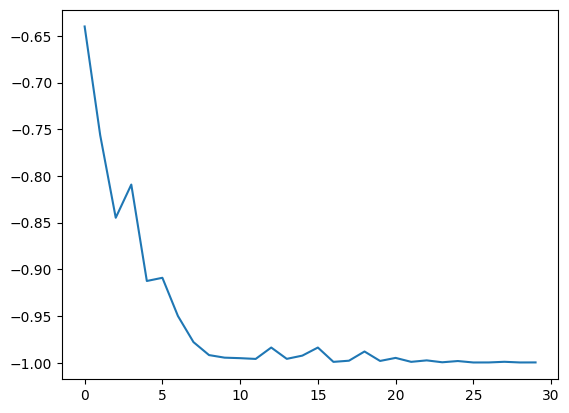

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork2(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 30):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_result, predictions, actual = eval(model, device, train_loader)
    test_result, predictions, actual = eval(model, device, test_loader)
    test_results.append(predictions)
    losses.append(loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_result:.2f}%, '
          f'Test: {100 * test_result:.2f}%')

plt.plot(losses)
plt.show()

In [ ]:
def label_people(array):
    labels = []
    for entry in array:
        if entry == 0:
            labels.append("adult")
        elif entry == 1:
            labels.append("child")
        else:
            labels.append("unknown")
    return labels

In [ ]:
label_people(test_results[-1])

['adult',
 'adult',
 'adult',
 'adult',
 'child',
 'child',
 'adult',
 'adult',
 'child',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'child',
 'child',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'child',
 'adult',
 'child',
 'adult']

# Test Results GCN

In [ ]:
for batch in test_loader:
  print(batch)

DataBatch(edge_index=[2, 13723], weight=[13723], x=[1209, 39], y=[31], num_nodes=1209, batch=[1209], ptr=[32])


In [ ]:
original_label_value = []
for batch in test_loader:
  original_label_value = batch.y

In [ ]:
label_people(original_label_value)

['adult',
 'child',
 'adult',
 'adult',
 'child',
 'child',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'child',
 'adult',
 'adult',
 'adult',
 'child',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'child',
 'adult',
 'child',
 'adult',
 'child',
 'adult']

# Using EDGE Conv layers

In [ ]:
test_results_edge = []
test_results_edge_original = []

Epoch: 01, Loss: -0.6793, Train: 79.84%, Test: 74.19%
Epoch: 02, Loss: -0.7449, Train: 79.84%, Test: 74.19%
Epoch: 03, Loss: -0.8642, Train: 79.84%, Test: 74.19%
Epoch: 04, Loss: -0.9162, Train: 79.84%, Test: 74.19%
Epoch: 05, Loss: -0.9073, Train: 79.84%, Test: 74.19%
Epoch: 06, Loss: -0.9495, Train: 83.87%, Test: 74.19%
Epoch: 07, Loss: -0.8995, Train: 84.68%, Test: 74.19%
Epoch: 08, Loss: -0.9917, Train: 97.58%, Test: 87.10%
Epoch: 09, Loss: -0.9918, Train: 100.00%, Test: 83.87%
Epoch: 10, Loss: -0.9978, Train: 100.00%, Test: 80.65%
Epoch: 11, Loss: -0.9953, Train: 98.39%, Test: 83.87%
Epoch: 12, Loss: -0.9988, Train: 99.19%, Test: 83.87%
Epoch: 13, Loss: -0.9954, Train: 100.00%, Test: 83.87%
Epoch: 14, Loss: -0.9990, Train: 100.00%, Test: 83.87%
Epoch: 15, Loss: -0.9985, Train: 100.00%, Test: 83.87%
Epoch: 16, Loss: -0.9982, Train: 100.00%, Test: 83.87%
Epoch: 17, Loss: -0.9974, Train: 100.00%, Test: 80.65%
Epoch: 18, Loss: -0.9608, Train: 98.39%, Test: 87.10%
Epoch: 19, Loss: -0.9

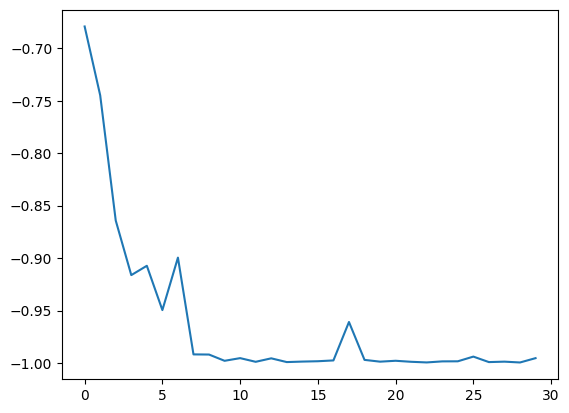

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork2(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 30):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_result, predictions, actual = eval(model, device, train_loader)
    test_result, predictions, actual = eval(model, device, test_loader)
    test_results_edge.append(predictions)
    test_results_edge_original.append(actual)
    losses.append(loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_result:.2f}%, '
          f'Test: {100 * test_result:.2f}%')

plt.plot(losses)
plt.show()

In [ ]:
label_people(test_results_edge[-1]), label_people(test_results_edge_original[-1])

(['adult',
  'adult',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'child',
  'adult'],
 ['adult',
  'child',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'child',
  'adult',
  'child',
  'adult'])

# GAT

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import from_networkx
import networkx as nx
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

In [ ]:
test_results_GAT = []
test_results_original = []

Epoch: 1, Loss: 0.5776, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 2, Loss: 0.5152, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 3, Loss: 0.4819, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 4, Loss: 0.4724, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 5, Loss: 0.4499, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 6, Loss: 0.4179, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 7, Loss: 0.4172, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 8, Loss: 0.3827, Train Acc: 0.8145, Test Acc: 0.6774
Epoch: 9, Loss: 0.3789, Train Acc: 0.8226, Test Acc: 0.6774
Epoch: 10, Loss: 0.3600, Train Acc: 0.8548, Test Acc: 0.7419
Epoch: 11, Loss: 0.3402, Train Acc: 0.8952, Test Acc: 0.8387
Epoch: 12, Loss: 0.3003, Train Acc: 0.9194, Test Acc: 0.8387
Epoch: 13, Loss: 0.2740, Train Acc: 0.9758, Test Acc: 0.8387
Epoch: 14, Loss: 0.2867, Train Acc: 0.9758, Test Acc: 0.8387
Epoch: 15, Loss: 0.3200, Train Acc: 0.9677, Test Acc: 0.8710
Epoch: 16, Loss: 0.2823, Train Acc: 0.9677, Test Acc: 0.8710
Epoch: 17, Loss: 0.2306, Train Ac

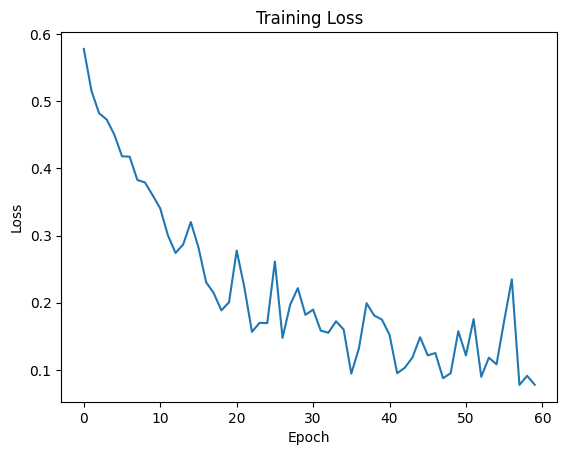

In [ ]:
# Graph network dataset preparation
class DevDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        corr_path_list = sorted(os.listdir(corr_matrices_dir), key=lambda x: int(x[-8:-4]))
        pcorr_path_list = sorted(os.listdir(pcorr_matrices_dir), key=lambda x: int(x[-8:-4]))
        labels = torch.tensor(np.loadtxt(labels_file, delimiter=','), dtype=torch.long)

        graphs = []
        for i in range(len(corr_path_list)):
            corr_matrix = np.loadtxt(f'{corr_matrices_dir}/corr_{i:04d}.csv', delimiter=',')
            pcorr_matrix = np.loadtxt(f'{pcorr_matrices_dir}/pcorr_{i:04d}.csv', delimiter=',')
            pcorr_graph = nx.from_numpy_array(pcorr_matrix != 0)
            pcorr_data = from_networkx(pcorr_graph)
            pcorr_data.x = torch.tensor(corr_matrix, dtype=torch.float)
            pcorr_data.y = labels[i]
            graphs.append(pcorr_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

# Define the GAT model
class GraphNetwork(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphNetwork, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.conv2 = GATConv(8 * hidden_channels, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

# Setup dataset, model, and training
dataset = DevDataset('dataset_pyg')
dataset = dataset.shuffle()
train_dataset, test_dataset = dataset[:int(len(dataset) * 0.8)], dataset[int(len(dataset) * 0.8):]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNetwork(dataset.num_node_features, 32, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.NLLLoss()

# Training and evaluation functions
def train():
    model.train()
    total_loss = 0
    for data in DataLoader(train_dataset, batch_size=32, shuffle=True):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
    return correct / total, pred, data.y

# Run training and testing
losses = []  # List to store losses for plotting
for epoch in range(60):
    loss = train()
    train_acc, prediction, original = test(DataLoader(train_dataset, batch_size=32))
    test_acc, prediction, original = test(DataLoader(test_dataset, batch_size=32))
    test_results_GAT.append(prediction)
    test_results_original.append(original)
    losses.append(loss)  # Append the average loss over the epoch
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Visualize training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
label_people(test_results_GAT[-1]), label_people(test_results_original[-1])

(['child',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'child',
  'child',
  'adult',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'child'],
 ['child',
  'adult',
  'child',
  'adult',
  'child',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'adult',
  'adult',
  'adult',
  'adult',
  'adult',
  'child',
  'child',
  'adult',
  'child'])

# Graph Sage

In [ ]:
test_results_sage = []
test_results_sage_original = []

Epoch: 1, Loss: 0.5398, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 2, Loss: 0.5222, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 3, Loss: 0.5211, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 4, Loss: 0.5170, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 5, Loss: 0.5116, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 6, Loss: 0.5063, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 7, Loss: 0.4891, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 8, Loss: 0.4745, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 9, Loss: 0.4513, Train Acc: 0.8065, Test Acc: 0.8065
Epoch: 10, Loss: 0.4413, Train Acc: 0.8387, Test Acc: 0.8065
Epoch: 11, Loss: 0.4113, Train Acc: 0.8710, Test Acc: 0.8710
Epoch: 12, Loss: 0.4084, Train Acc: 0.9274, Test Acc: 0.8710
Epoch: 13, Loss: 0.3835, Train Acc: 0.9113, Test Acc: 0.9032
Epoch: 14, Loss: 0.3680, Train Acc: 0.9597, Test Acc: 0.9032
Epoch: 15, Loss: 0.3554, Train Acc: 0.9274, Test Acc: 0.9032
Epoch: 16, Loss: 0.3349, Train Acc: 0.9516, Test Acc: 0.9032
Epoch: 17, Loss: 0.3262, Train Ac

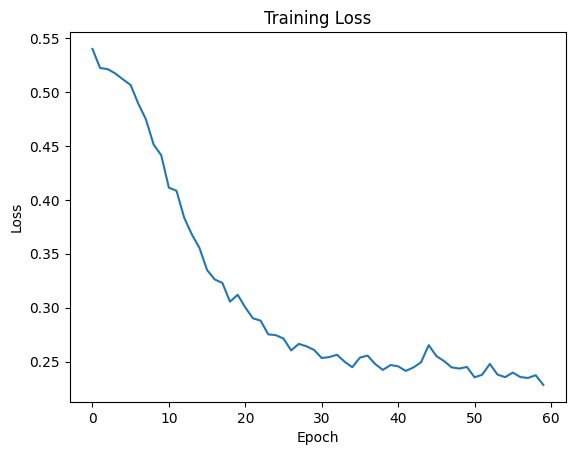

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import from_networkx
import networkx as nx
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure



# Define the GraphSAGE model
class GraphNetwork(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphNetwork, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, normalize=True)
        self.conv2 = SAGEConv(hidden_channels, out_channels, normalize=True)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

# Setup dataset, model, and training
dataset = DevDataset('dataset_pyg')
dataset = dataset.shuffle()
train_dataset, test_dataset = dataset[:int(len(dataset) * 0.8)], dataset[int(len(dataset) * 0.8):]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNetwork(dataset.num_node_features, 32, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.NLLLoss()

# Training and evaluation functions
losses = []  # List to store loss for each epoch for plotting
def train():
    model.train()
    total_loss = 0
    for data in DataLoader(train_dataset, batch_size=32, shuffle=True):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
    return correct / total, pred, data.y

# Run training and testing
for epoch in range(60):
    loss = train()
    losses.append(loss)  # Store loss for plotting
    train_acc, prediction, original = test(DataLoader(train_dataset, batch_size=32))
    test_acc, prediction, original = test(DataLoader(test_dataset, batch_size=32))
    test_results_sage.append(prediction)
    test_results_sage_original.append(original)
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Visualize training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
import shutil
import os

def zip_folder(folder_path, zip_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return

    # Create a zip file
    shutil.make_archive(zip_path, 'zip', folder_path)

# Replace 'folder_path' with the path to your folder
folder_path = '/path/to/your/folder'

# Replace 'zip_path' with the path where you want to save the zip file
zip_path = '/path/to/your/zipfile.zip'

zip_folder(folder_path, zip_path)

# Move the zip file to the download directory
shutil.move(zip_path, '/content/')

Folder does not exist.


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/zipfile.zip'

In [ ]:
label_people(test_results_sage[-1]), label_people(test_results_sage_original[-1])

In [ ]:
# 3rd attempt
!pip install torchdiffeq

Epoch: 1, Loss: 0.6315, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 2, Loss: 0.5210, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 3, Loss: 0.5202, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 4, Loss: 0.5115, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 5, Loss: 0.5005, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 6, Loss: 0.4961, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 7, Loss: 0.4843, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 8, Loss: 0.4716, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 9, Loss: 0.4559, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 10, Loss: 0.4375, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 11, Loss: 0.3991, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 12, Loss: 0.3663, Train Acc: 0.7823, Test Acc: 0.8065
Epoch: 13, Loss: 0.3335, Train Acc: 0.9113, Test Acc: 0.9032
Epoch: 14, Loss: 0.3061, Train Acc: 0.9113, Test Acc: 0.9032
Epoch: 15, Loss: 0.2486, Train Acc: 0.9194, Test Acc: 0.9032
Epoch: 16, Loss: 0.2405, Train Acc: 0.9194, Test Acc: 0.8710
Epoch: 17, Loss: 0.1759, Train Ac

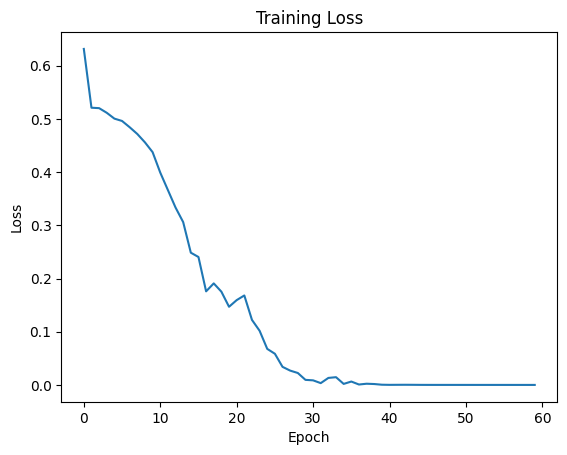

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import Sequential, Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

# Define the Graph Neural ODE model
class GDEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GDEModel, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels

        # Define the dynamic model for the nodes
        self.node_dynamic_model = Sequential(
            Linear(in_channels, hidden_channels),
            nn.ReLU(),
            Linear(hidden_channels, out_channels)
        )

    def forward(self, t, x):
        return self.node_dynamic_model(x)

class GDELayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GDELayer, self).__init__()
        self.gde_model = GDEModel(in_channels, hidden_channels, in_channels)

    def forward(self, x, edge_index):
        t = torch.tensor([0.0, 1.0], dtype=torch.float32, device=x.device)  # Time steps
        x = odeint(self.gde_model, x, t, method='dopri5', options={'max_num_steps': 500})
        return x[-1]  # Return the final node states after the ODE integration

class GraphNetwork(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphNetwork, self).__init__()
        self.conv = GDELayer(in_channels, hidden_channels)
        self.lin = Linear(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = global_mean_pool(x, data.batch)  # Global pooling
        x = F.log_softmax(self.lin(x), dim=1)  # Log-softmax output
        return x

# Setup dataset, model, and training
# Assuming you have `train_dataset` and `test_dataset` defined

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modify this part according to your dataset loading and preprocessing logic

model = GraphNetwork(in_channels=dataset.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.NLLLoss()

# Training and evaluation functions
losses = []  # List to store loss for each epoch for plotting

def train():
    model.train()
    total_loss = 0
    for data in DataLoader(train_dataset, batch_size=32, shuffle=True):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
    return correct / total

# Run training and testing
for epoch in range(60):
    loss = train()
    losses.append(loss)  # Store loss for plotting
    train_acc = test(DataLoader(train_dataset, batch_size=32))
    test_acc = test(DataLoader(test_dataset, batch_size=32))
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Visualize training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
